In [2]:
import sca

# Import common libraries
import numpy as np
import scipy.io as scipio
import matplotlib.pyplot as plt
from math import pi,e,log,sqrt

###############################################3
def smooth(x,window_len=11,window='hanning'):
#    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    s=np.pad(x,int(window_len/2),'edge')
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  #[int(window_len/2):-int(window_len/2)]
 
###############################################################
##################
# Some constants and variables
FF = 1.0			# Dependence of Q on frequency
HH = 2.76e5			# Activation enthalpy
RR = 8.314472		# Gas constant
QQ = 1.e2			# Attenuation Q factor
bb = -8.1e-5		# anharmonic dlnVp/Dt from Christensen 1979
		# background geothermal gradient
zero=1.e-12
kelvin=273.15
kkkk=2.0
nu = 0.3
Km = 10.6589e1
Gm = 2.0630e1
rom = 2.9			# density of solid rock matrix

######################################
# Read matlab file with xzv profile
profile=scipio.loadmat('Curves_finalthesis_magma.mat',struct_as_record=True) #Curves_finalthesis_magma.mat

In [3]:
Z=profile['Zbackground']
Vp=profile['Vpcaldera']
Vp=Vp*0+5
vpzmeanm = profile['Vpbackground']
vpzmeanm=vpzmeanm[0,0:50:1]

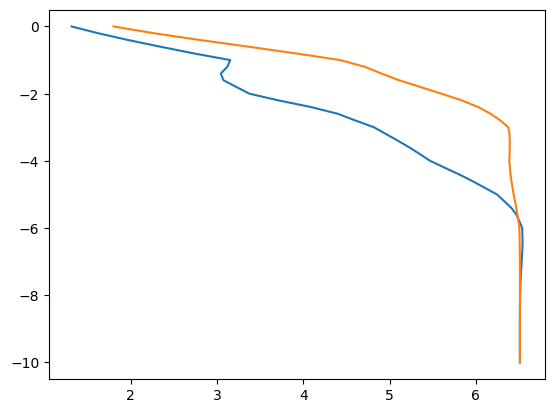

In [4]:
Z=profile['Zbackground']
Vp=profile['Vpcaldera']
#Vp=Vp*0+5
vpzmeanm = profile['Vpbackground']
#vpzmeanm=vpzmeanm[0,0:50:1]
Vpano = Vp-vpzmeanm
deltalogv = np.log(Vp)-np.log(vpzmeanm)
plt.plot(Vp,Z)
plt.plot(vpzmeanm,Z)

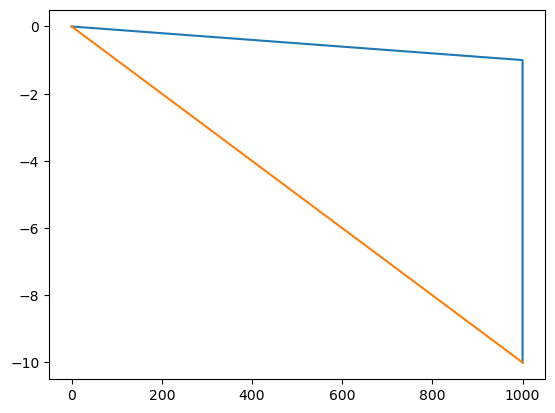

In [5]:
zz=Z
###############################
# Water porosity
###############################
fluid='w'

rofMelt = 2.8 #2.3	# density of melt
rofWater = 0.7		# density of water
KiMelt = 2.0e1 #1.27e1

# background T

# Low gradient in loose sediments, top 100 m. Steep gradient to 1200 m, then more gradual
thot0 = np.where(-zz<10,100*(-zz),1000)
thot1_sol = np.where(zz > -1, 1000 * -zz, 1000)

#thot1_sol = np.where(-zz<0,1050*(-zz),1050)
thot=thot0
thot_sol=thot1_sol

plt.plot(thot_sol,zz)
plt.plot(thot,zz)
thot+=kelvin
thot_sol+=kelvin
T0=thot
T = T0*1.0


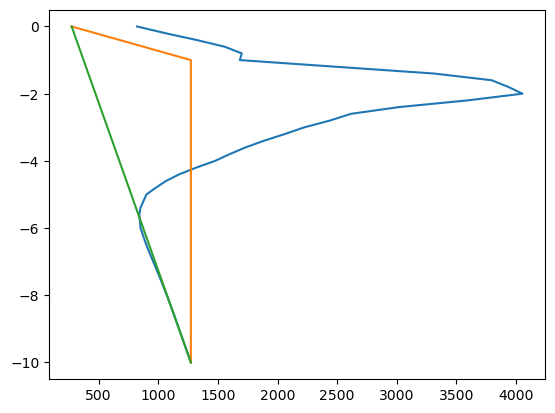

In [6]:
const = FF*HH/pi/RR/QQ
# Estimate temperature anomaly from Vp anomaly using Karato (1993)
# Assuming anomaly is entirely a thermal effect
logV = np.log(Vp)
nsteps=51
idlogv=deltalogv/(nsteps*1.0)
for l in range(1,nsteps):
	dtdlnv = 1./(bb-const/T**2.)
	T = T+idlogv*dtdlnv

# Clip T below 10 Celsius
T[T<283] = 283.
plt.plot(T,zz)
plt.plot(thot_sol,zz)
plt.plot(thot,zz)

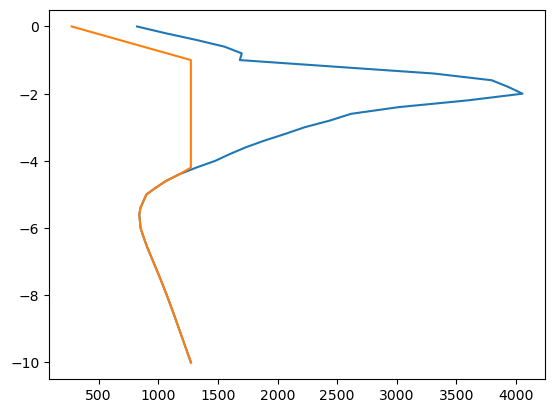

In [7]:
##########################
# Isolate part of anomaly above solidus
# Druitt et al 2016: entrapment temp of 900°C for Kameni samples in Table 3 and Fig 11
# solidus = 900.+273. 
solidus = 1000.+273. 

soliduscurve=thot_sol*1.0
#plt.plot(soliduscurve,zz)
#soliduscurve[12:15]=np.linspace(soliduscurve[12],solidus,3)
#plt.plot(soliduscurve,zz)
#soliduscurve[15:51]=solidus
#plt.plot(soliduscurve,zz)
Tmush=T-solidus #in kelvin 
Tmush[Tmush<0]=0.


# Clipped T
Tclip=np.empty(T.shape)
Tclip = T * 1.0
plt.plot(Tclip,zz)
Tclip[Tclip>=soliduscurve] = soliduscurve[Tclip>=soliduscurve]

plt.plot(Tclip,zz)
#########################################
nsteps=100
# Excess anomaly not due to temperature
dT = (Tclip-T0)/(nsteps*1.0)

dlogv = np.zeros(Vp.shape)
ttemp = T0*1.0
for l in range(1,nsteps):
	ttemp = ttemp+dT
	dlnvdt = bb-const/ttemp**2.
	dlogv = dlogv+dlnvdt*dT
	
Vpanot = vpzmeanm*np.exp(dlogv)-vpzmeanm

if fluid == 'm':
	Vpanor = Vpano - Vpanot
	Vpref = vpzmeanm + Vpanot
elif fluid == 'w':
	Vpanor = Vpano
	Vpref = vpzmeanm

In [8]:
######################################################

#Vpref = vpzmeanm
# Calculate vs from vp using Brocher's empirical relation:
Vsref = 0.7858 - 1.2344*Vpref + 0.7949*Vpref**2. - 0.1238*Vpref**3. + 0.64e-2*Vpref**4.
# Moduli of the matrix
Km = rom*(Vpref**2.-4./3.*Vsref**2.)
Gm = rom*Vsref**2.
if fluid == 'm':
    Ki = KiMelt 	# bulk modulus of fluid
    rof = rofMelt
elif fluid == 'w':
    Ki = kkkk
    rof = rofWater		# bulk modulus of fluid
Gi = zero		# shear modulus of fluid



###### 1 #########
ai = 0.05		# Aspect ratio of inclusions
am = 1.0		# Aspect ratio of solid grains

# Iterate until water/melt fraction matches observed excess Vp
dmelt=0.002
water1=np.ones(Vp.shape)*dmelt		# melt fraction or porosity
for x in np.ndindex(Vpref.shape):
	vpdiff=-2.0
	while ( vpdiff <= 0 and water1[x] < 1.):
		me=water1[x]	# porosity in volume fraction
		so = 1.-me	# solid volume fraction
		roe = rof*me+so*rom	#effective density
# Calculate moduli
# Relaxed, low frequency case - dry + Gassman
#  calculating moduli for dry composite material using Berryman self-consistent approach
#  then using Gassman 1951 to add the liquid to interconnected pores
		Kd,Gd = sca.mod_b_scalar(Km[x],zero,Gm[x],zero,am,ai,so,me)
		Ks,Gs = sca.gassman_2(Kd,Gd,Km[x],Gm[x],Ki,Gi,me)
			
		Vpr=sqrt((Ks+4.0/3.0*Gs)/roe)
		vpdiff=Vp[x]-Vpr
#		print(me,Ks,Gs,Vpr,vpdiff)		
		water1[x] = water1[x]+dmelt

###### 2  #########
ai = 0.5		# Aspect ratio of inclusions
am = 1.0		# Aspect ratio of solid grains

# Iterate until water/melt fraction matches observed excess Vp
dmelt=0.002
water2=np.ones(Vp.shape)*dmelt		# melt fraction or porosity
for x in np.ndindex(Vpref.shape):
	vpdiff=-2.0
	while ( vpdiff <= 0 and water2[x] < 1.):
		me=water2[x]
		so = 1.-me
		roe = rof*me+so*rom
# Calculate moduli
# Relaxed, low frequency case - dry + Gassman
#  calculating moduli for dry composite material using Berryman self-consistent approach
#  then using Gassman 1951 to add the liquid to interconnected pores
		Kd,Gd = sca.mod_b_scalar(Km[x],zero,Gm[x],zero,am,ai,so,me)
		Ks,Gs = sca.gassman_2(Kd,Gd,Km[x],Gm[x],Ki,Gi,me)
			
		Vpr=sqrt((Ks+4.0/3.0*Gs)/roe)
		vpdiff=Vp[x]-Vpr
#		print(me,Ks,Gs,Vpr,vpdiff)		
		water2[x] = water2[x]+dmelt



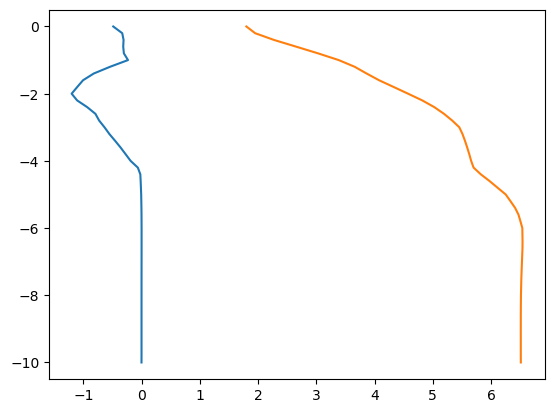

In [9]:
###############################
# Melt porosity
###############################
fluid='m'

##################
# Parameters for melt

rofMelt = 2.8 #2.3	# density of melt
rofWater = 0.7		# density of water
# background T
thot0 = np.where(-zz<10,100*(-zz),1000)
thot1_sol = np.where(-zz<0,1000*(-zz),1000)
thot=thot0
thot_sol=thot1_sol

#plt.plot(thot_sol,zz)
#plt.plot(thot,zz)
thot+=kelvin
thot_sol+=kelvin
T0=thot
T = T0*1.0
########
########
const = FF*HH/pi/RR/QQ
# Estimate temperature anomaly from Vp anomaly using Karato (1993)
# Assuming anomaly is entirely a thermal effect
logV = np.log(Vp)
nsteps=50
idlogv=deltalogv/(nsteps*1.0)
for l in range(1,nsteps):
	dtdlnv = 1./(bb-const/T**2.)
	T = T+idlogv*dtdlnv

# Clip T below 10 Celsius
T[T<283] = 283.


##########################
# Isolate part of anomaly above solidus

#########################################
nsteps=100
# Excess anomaly not due to temperature
dT = (Tclip-T0)/(nsteps*1.0)
dlogv = np.zeros(Vp.shape)
ttemp = T0*1.0
for l in range(1,nsteps):
	ttemp = ttemp+dT
	dlnvdt = bb-const/ttemp**2.
	dlogv = dlogv+dlnvdt*dT
	
Vpanot = vpzmeanm*np.exp(dlogv)-vpzmeanm

if fluid == 'm':
	Vpanor = Vpano - Vpanot
	Vpref = vpzmeanm + Vpanot
elif fluid == 'w':
	Vpanor = Vpano
	Vpref = vpzmeanm
    
plt.plot(Vpanor,zz)
plt.plot(Vpref,zz)

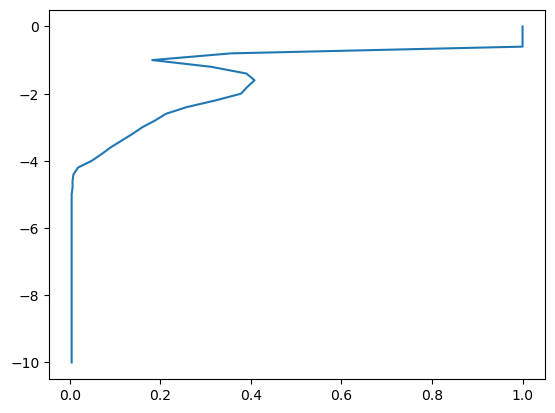

In [10]:
#Vpref = vpzmeanm
# Calculate vs from vp using Brocher's empirical relation:
Vsref = 0.7858 - 1.2344*Vpref + 0.7949*Vpref**2. - 0.1238*Vpref**3. + 0.64e-2*Vpref**4.
# Moduli of the matrix
Km = rom*(Vpref**2.-4./3.*Vsref**2.)
Gm = rom*Vsref**2.
if fluid == 'm':
    Ki = KiMelt	# bulk modulus of fluid
    rof = rofMelt
elif fluid == 'w':
    Ki = kkkk	# bulk modulus of fluid
    rof = rofWater
Gi = zero		# shear modulus of fluid


###### 1 #########
ai = 0.05		# Aspect ratio of inclusions
am = 1.0		# Aspect ratio of solid grains

dmelt=0.002
melt1=np.ones(Vp.shape)*dmelt		# melt fraction or porosity
for x in np.ndindex(Vpref.shape):
	vpdiff=-2.0
	while ( vpdiff <= 0 and melt1[x] < 1.):
		me=melt1[x]
		so = 1.-me
		roe = rof*me+so*rom
# Calculate moduli
# Relaxed, low frequency case - dry + Gassman
		Kd,Gd = sca.mod_b_scalar(Km[x],zero,Gm[x],zero,am,ai,so,me)
		Ks,Gs = sca.gassman_2(Kd,Gd,Km[x],Gm[x],Ki,Gi,me)
			
		Vpr=sqrt((Ks+4.0/3.0*Gs)/roe)
		vpdiff=Vp[x]-Vpr
#		print(me,Ks,Gs,Vpr,vpdiff)		
		melt1[x] = melt1[x]+dmelt

###### 2 #########
ai = 0.5		# Aspect ratio of inclusions
am = 1.0		# Aspect ratio of solid grains

dmelt=0.002
melt2=np.ones(Vp.shape)*dmelt		# melt fraction or porosity
for x in np.ndindex(Vpref.shape):
	vpdiff=-2.0
	while ( vpdiff <= 0 and melt2[x] < 1.):
		me=melt2[x]
		so = 1.-me
		roe = rof*me+so*rom
# Calculate moduli
# Relaxed, low frequency case - dry + Gassman
		Kd,Gd = sca.mod_b_scalar(Km[x],zero,Gm[x],zero,am,ai,so,me)
		Ks,Gs = sca.gassman_2(Kd,Gd,Km[x],Gm[x],Ki,Gi,me)
			
		Vpr=sqrt((Ks+4.0/3.0*Gs)/roe)
		vpdiff=Vp[x]-Vpr
#		print(me,Ks,Gs,Vpr,vpdiff)		
		melt2[x] = melt2[x]+dmelt

plt.plot(melt2,zz)

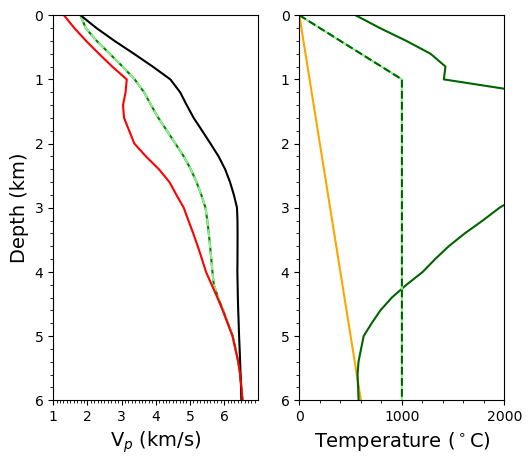

In [11]:
##############################
fig2=plt.figure(figsize=(9,5));

ax = fig2.add_subplot(131)
plt.plot(Vpref[:],-Z[:],color='green',linestyle='-')
plt.plot(Vpref[:],-Z[:],color='lightgreen',linestyle='--')

plt.plot(vpzmeanm[:],-Z[:],color='black',linestyle='-')
plt.plot(Vp[:],-Z[:],color='red')
plt.xlabel('V$_p$ (km/s)',fontsize=14)
plt.ylabel('Depth (km)',fontsize=14)

majorx_ticks = np.arange(-2, 7, 1)
minorx_ticks = np.arange(-2, 7, 0.1)
majory_ticks = np.arange(0, 10, 1)
minory_ticks = np.arange(0, 10, 0.2)
ax.set_xticks(majorx_ticks)
ax.set_xticks(minorx_ticks, minor=True)
ax.set_yticks(majory_ticks)
ax.set_yticks(minory_ticks, minor=True)
# And a corresponding grid
ax.grid(which='both')
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.ylim(6,0)
plt.xlim(1,7)

ax = fig2.add_subplot(132)
plt.plot(T0[:]-273,-Z[:],color='orange')
#plt.plot(newT0[:]-273,-Z[:],color='blue')
plt.plot(T[:]-273,-Z[:],color='darkgreen')
plt.plot(soliduscurve[:]-273,-Z[:],color='lightgreen') #-273 is kelvin to celsius 
plt.plot(soliduscurve[:]-273,-Z[:],color='darkgreen',linestyle='--')
#plt.plot(Tmush[25,:],Z[25,:],color='red')
plt.xlabel('Temperature ($^\circ$C)',fontsize=14)

majorx_ticks = np.arange(0, 5000, 1000)
minorx_ticks = np.arange(0, 5000, 200)
majory_ticks = np.arange(0, 10, 1)
minory_ticks = np.arange(0, 10, 0.2)
ax.set_xticks(majorx_ticks)
ax.set_xticks(minorx_ticks, minor=True)
ax.set_yticks(majory_ticks)
ax.set_yticks(minory_ticks, minor=True)
# And a corresponding grid
ax.grid(which='both')
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.ylim(6,0)
plt.xlim(0,2000)

fileplot='caldera meltpg.pdf'
#plt.savefig(fileplot,dpi=100)
plt.show()

NameError: name 'water0' is not defined

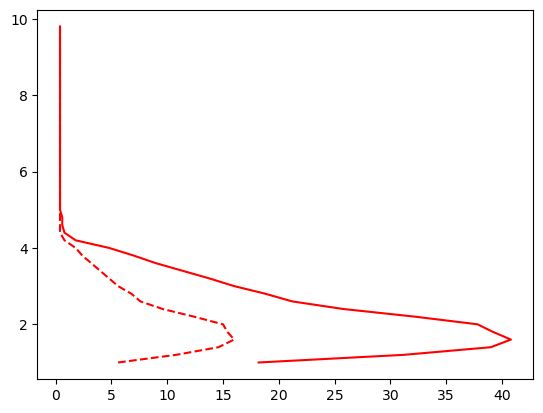

In [12]:
### HARD-WIRED TO PLOT WATER AND MELT PORTIONS FOR DIFFERENT DEPTHS SEPARATELY !!! ###

ax = fig2.add_subplot(133)
#plt.plot(phiz[:]Z[25,:],color='blue')
plt.plot(melt1[5:50]*100,-Z[5:50],color='red', linestyle='--')
plt.plot(melt2[5:50]*100,-Z[5:50],color='red')
plt.plot(water0[0:5]*100,-Z[0:5],color='lightblue')
plt.plot(water00[0:5]*100,-Z[0:5],color='blue')
plt.plot(water1[0:5]*100,-Z[0:5],color='lightblue', linestyle='--')
plt.plot(water2[0:5]*100,-Z[0:5],color='blue',linestyle='--')
plt.plot(np.linspace(0,100,14),-Z[0:14]*0+0.8,color='black')
plt.plot(np.linspace(0,100,14),-Z[0:14]*0+1,color='black')
#plt.plot(np.linspace(0,50,14),-Z[0:14]*0+2.8,color='black')

plt.xlabel('Melt/Water Fraction $\phi$  (%)',fontsize=14)
#ax.grid()


majorx_ticks = np.arange(0, 110, 10)
minorx_ticks = np.arange(0, 110, 1)
majory_ticks = np.arange(0, 10, 1)
minory_ticks = np.arange(0, 10, 0.2)
ax.set_xticks(majorx_ticks)
ax.set_xticks(minorx_ticks, minor=True)
ax.set_yticks(majory_ticks)
ax.set_yticks(minory_ticks, minor=True)
# And a corresponding grid
ax.grid(which='both')
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.ylim(6,0)
plt.xlim(0,50)#40)
plt.ylabel('Depth (km)',fontsize=14)
#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 14}

#plt.rc('font', **font)
fileplot='rif melt.pdf'
#plt.savefig(fileplot,dpi=500)
plt.show()


In [ ]:
water0=water1
water00=water2


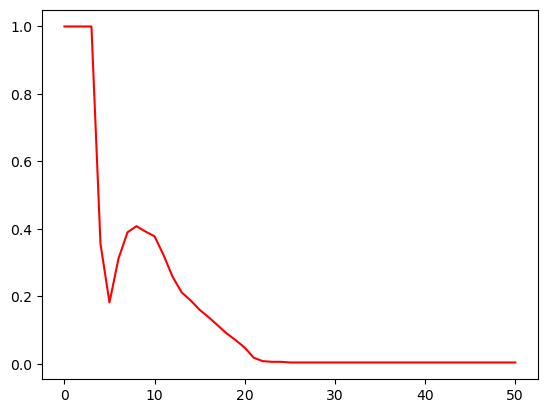

In [16]:
plt.plot(melt2,color='red')

In [17]:
type(melt2)

numpy.ndarray

In [18]:
np.savetxt("output1.csv", melt1, delimiter=",")

In [19]:
np.savetxt("output2.csv", melt2, delimiter=",")